# Making simulated experiments and comparing several conformalized models using conformal prediction metrics.

In [1]:
# libraries used
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')
sns.set_palette("Set1")

# used models 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# split conformal prediction
from nonconformist.icp import IcpRegressor
from nonconformist.nc import RegressorNc, AbsErrorErrFunc

# train, calibration and test spliting
from sklearn.model_selection import train_test_split

Making simulator with several types of simulation, generating noisy data:

In [2]:
# simulation class
class simulation:
    def __init__(self, dim = 20, coef = 0.3):
        self.dim = dim
        self.coef = coef
    
    def change_dim(self, new_dim):
        self.dim = new_dim
        return self
        
    def homoscedastic(self, n, random_seed = 1250):
        np.random.seed(random_seed)
        X = np.random.uniform(low = -1.5, high = 1.5, size = (n, self.dim))
        y = np.random.normal(self.coef*X[:, 0], scale = 1, size = n)
        self.X, self.y = X, y
    
    def bimodal(self, n, random_seed = 1250):
        np.random.seed(random_seed)
        X = np.random.uniform(low = -1.5, high = 1.5, size = (n, self.dim))
        f_x = (X[:, 0] - 1)**(2)*(X[:, 0] + 1)
        g_x = 2*int(X[:, 0] >= -0.5)*np.sqrt(X[:,0] + 0.5)
        sigma_x = np.sqrt(0.25 + np.abs(X[:0]))
        y = (0.5*np.random.normal(f_x - g_x, scale = sigma_x, size = n) + 
             0.5*np.random.normal(f_x + g_x, scale = sigma_x, size = n))
        self.X, self.y = X, y
    
    def heteroscedastic(self, n, random_seed = 1250):
        np.random.seed(random_seed)
        X = np.random.uniform(low = -1.5, high = 1.5, size = (n, self.dim))
        y = np.random.normal(self.coef*X[:, 0], scale = np.sqrt(1 + self.coef*np.abs(X[:, 0])), size = n)
        self.X, self.y = X, y
    
    def homoscedastic_quantiles(self, X_grid, sig):
        q = [sig/2, 1 - sig/2]
        lower = stats.norm.ppf(np.repeat(q[0], X_grid.shape[0]), loc = self.coef*X_grid, scale = 1)
        upper = stats.norm.ppf(np.repeat(q[1], X_grid.shape[0]), loc = self.coef*X_grid, scale = 1)
        interval = np.vstack((lower, upper)).T 
        return interval
    
    def homoscedastic_r(self, X_grid, B = 1000):
        y_mat = np.zeros((X_grid.shape[0], B))
        for i in range(X_grid.shape[0]):
            y_mat[i, :] = np.random.normal(self.coef*X_grid[i], scale = 1, size = B)
        return y_mat
    
    def heteroscedastic_quantiles(self, X_grid, sig):
        q = [sig/2, 1 - sig/2]
        lower = stats.norm.ppf(np.repeat(q[0], X_grid.shape[0]), loc = self.coef*X_grid, 
                               scale = np.sqrt(1 + self.coef*np.abs(X_grid)))
        upper = stats.norm.ppf(np.repeat(q[1], X_grid.shape[0]), loc = self.coef*X_grid, 
                               scale = np.sqrt(1 + self.coef*np.abs(X_grid)))
        interval = np.vstack((lower, upper)).T 
        return interval
    
    def heteroscedastic_r(self, X_grid, B = 1000):
        y_mat = np.zeros((X_grid.shape[0], B))
        for i in range(X_grid.shape[0]):
            y_mat[i, :] = np.random.normal(self.coef*X_grid[i],
                                           scale = np.sqrt(1 + self.coef*np.abs(X_grid[i])),
                                           size = B)
        return y_mat
    
# shuffling and splitting in train, calibration and test sets
def split(X, y, test_size = 0.2, random_seed = 1250):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = test_size,
                                                        random_state = random_seed)
    X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size = 0.25,
                                                             random_state = random_seed)
    return {"X_train":X_train, "X_calib": X_calib, "X_test" : X_test, 
                "y_train" : y_train, "y_calib" : y_calib, "y_test": y_test}

Functions to generate calibration plots inspired in https://towardsdatascience.com/how-to-add-uncertainty-estimation-to-your-models-with-conformal-prediction-a5acdb86ea05

In [3]:
def calibration_curve(conf_estim, X, y, alphas = np.linspace(0.05, 1, 20, endpoint=True)):
    errors = []
    interval_sizes = []
    for a in alphas:
        pred = conf_estim.predict(X, significance = a)
        interval_sizes.append(np.mean([y-x for x, y in pred]))
        errors.append(1 - np.mean([x <= z and z <= y for (x,y), z in zip(pred, y)]))
    return errors, interval_sizes

# constant line for facetgrid
def const_line(*args, **kwargs):
    x = np.arange(0, 1, 0.001)
    y = x
    plt.plot(y, x, C='k')

def calibration_data(estimator, X, y, alphas = np.linspace(0.05, 1, 20, endpoint=True)):
    if isinstance(estimator, dict):
        error_dict, int_dict = {}, {}
        for estim in estimator:
            error_dict[estim], int_dict[estim] = calibration_curve(estimator[estim],X,y,alphas)
        error_dict["grid"], int_dict["grid"] = alphas, alphas
        error_df, int_df = pd.DataFrame(error_dict), pd.DataFrame(int_dict)
    else:
        error_dict = {}
        error_dict["model"], int_dict["model"] = calibration_curve(estimator,X,y,alphas)
        error_dict["grid"], int_dict["grid"] = alphas, alphas
        error_df, int_df = pd.DataFrame(error_dict), pd.DataFrame(int_dict)
    return [error_df, int_df]

def calibration_plots(estimator_list, X, y, alphas = np.linspace(0.05, 1, 20, endpoint=True)):
    calib_data = calibration_data(estimator_list, X, y, alphas)
    error_melt, int_melt = pd.melt(calib_data[0], id_vars = ['grid']), pd.melt(calib_data[1], id_vars = ['grid'])
    
    # first plotting and comparing each alpha in terms of coverage
    g = sns.FacetGrid(error_melt, col = "variable",
                  despine = False, margin_titles = True, 
                      legend_out = False, col_wrap = 3,
                      height = 6)
    # adding constant line to each plot
    g.map(const_line)
    # scatter plot
    g.map(sns.scatterplot, "grid", "value", color = "tab:orange")
    # axis names
    g.set_titles(col_template="{col_name}")
    g.set_xlabels(r"$\alpha$")
    g.set_ylabels(r"$1 - \bar{p}_{C}$")
    plt.tight_layout()
    plt.show()
    
    # plotting now the average interval length per significance level for each model
    plt.figure(figsize = (8, 6))
    sns.lineplot(data = int_melt, x = "grid", y = "value", hue = "variable")
    plt.xlabel(r"$\alpha$")
    plt.ylabel(r"$\bar{\Delta}_{C}$")
    plt.legend(loc = 1, title = "Base Model")
    plt.show()
    return calib_data

Function to make the dict list

In [4]:
# generating and splitting data and then fitting all models to split conformal
def make_models(sklearn_model_list, n = 7500, d = 20, coef = 2, random_seed = 1250):
    sim_obj = simulation(dim = d, coef = coef)
    sim_kind = getattr(sim_obj, "homoscedastic")
    sim_kind(n, random_seed = random_seed)
    # obtaining splits
    split_icp = split(sim_obj.X, sim_obj.y)
    # obtaining each split conformal prediction model
    icp_dict = {}
    for model in sklearn_model_list:
        icp_dict[model] = IcpRegressor(RegressorNc(sklearn_model_list[model], AbsErrorErrFunc()))
        icp_dict[model].fit(split_icp["X_train"], split_icp["y_train"])
        icp_dict[model].calibrate(split_icp["X_calib"], split_icp["y_calib"])
    return {"icp_models" : icp_dict, "X_test": split_icp["X_test"], "y_test": split_icp["y_test"]}

Finally, creating and placing our models into a model dictionary, and then obtainin the split conformal prediction dictionary:

In [5]:
# all models to be used:
mod_dict = {"Random Forest": RandomForestRegressor(random_state = 125),
           "Decision Tree": DecisionTreeRegressor(random_state = 10),
           "Linear Regression": LinearRegression(),
           "Lasso": LassoCV(cv = 5, random_state = 0),
           "KNN": KNeighborsRegressor(n_neighbors = 15)}
# obtaining icp dict
icp_mod = make_models(mod_dict)

In [6]:
icp_mod

{'icp_models': {'Random Forest': IcpRegressor(condition=<function BaseIcp.__init__.<locals>.<lambda> at 0x7feb654bc8b0>,
               nc_function=RegressorNc(err_func=<nonconformist.nc.AbsErrorErrFunc object at 0x7feb65488220>,
                                       model=RandomForestRegressor(random_state=125))),
  'Decision Tree': IcpRegressor(condition=<function BaseIcp.__init__.<locals>.<lambda> at 0x7feb333d2040>,
               nc_function=RegressorNc(err_func=<nonconformist.nc.AbsErrorErrFunc object at 0x7feb33428850>,
                                       model=DecisionTreeRegressor(random_state=10))),
  'Linear Regression': IcpRegressor(condition=<function BaseIcp.__init__.<locals>.<lambda> at 0x7feb333d20d0>,
               nc_function=RegressorNc(err_func=<nonconformist.nc.AbsErrorErrFunc object at 0x7feb65498520>,
                                       model=LinearRegression())),
  'Lasso': IcpRegressor(condition=<function BaseIcp.__init__.<locals>.<lambda> at 0x7feb333d

<ipython-input-3-58b5d6c1f5f9>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(y, x, C='k')
<ipython-input-3-58b5d6c1f5f9>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(y, x, C='k')
<ipython-input-3-58b5d6c1f5f9>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(y, x, C='k')
<ipython-input-3-58b5d6c1f5f9>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(y, x, C='k')
<ipython-input-3-58b5d6c1f5f9>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(y, x, C='k')


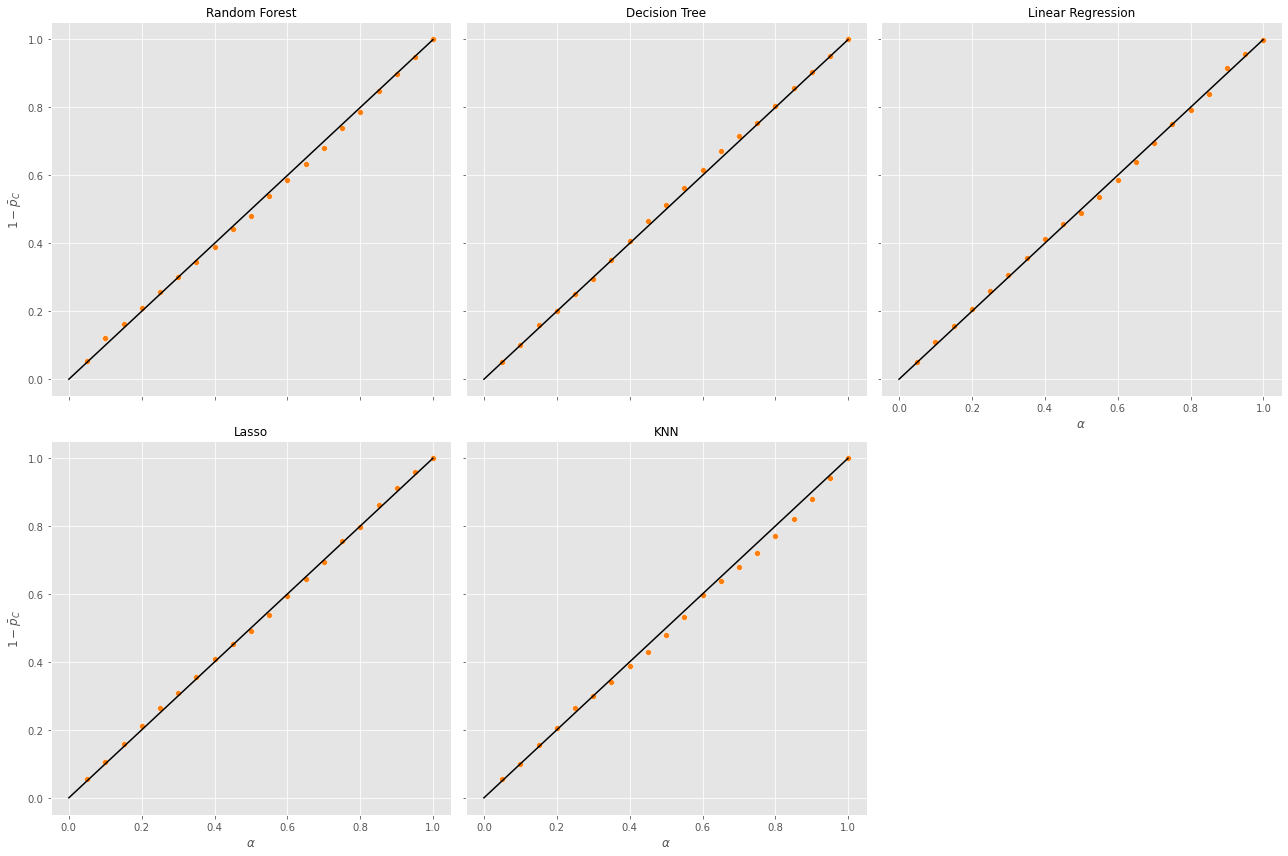

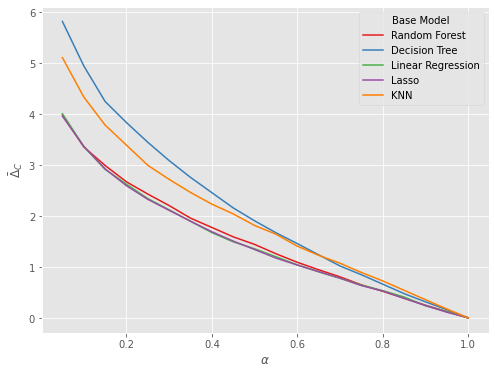

In [7]:
# obtaining calibration plots
calib_data = calibration_plots(icp_mod["icp_models"], icp_mod["X_test"], icp_mod["y_test"])

Fixing $\alpha = 0.1$ and obtaining estimated mean coverage and interval lenght for each base model:

In [8]:
calib_data[0].iloc[1, :]

Random Forest        0.122667
Decision Tree        0.099333
Linear Regression    0.108667
Lasso                0.104667
KNN                  0.100667
grid                 0.100000
Name: 1, dtype: float64

In [9]:
calib_data[1].iloc[1, :]

Random Forest        3.356036
Decision Tree        4.944973
Linear Regression    3.363257
Lasso                3.366672
KNN                  4.335464
grid                 0.100000
Name: 1, dtype: float64